# Example Regression: Database Jacob

In this example it will show how to work the library **deepensemble**. 

## Data

In this regression problem the data are generated from the following function:
$$
h_J(\textbf{x}) = \frac{1}{13} \left[ 10 sin (\pi x_1 x_2) + 20 \left(x_3 - \frac{1}{2} \right)^2 + 10x_4 + 5x_5 \right] - 1,
$$
where $ \textbf{x} = [x_1, ..., x_5] $ is the input vector and each component is generated by a uniform distribution random variable defined in the interval $ [0, 1] $. The $ h (\cdot) $ function looks like the $ [- 1, 1] $ range. This database is used in the works.

In [1]:
from config_test import *

from theano import config
from sklearn import model_selection
from matplotlib.pyplot import *
from theano import shared, config
import numpy as np

from deepensemble.metrics import *
from deepensemble.utils import *

N = 1000

X, y = jacobs(sample_len=N, seed=42)
y = np.array(y[:, np.newaxis], dtype=config.floatX)
X = np.array(X, dtype=config.floatX)
t = np.arange(N)

# Added Noise
s_noise = 0.01
nu = np.random.randn(N, 1) * s_noise
# nu[np.random.rand(N,1) > 0.95] += 0.2

z = y

n_train = int(N * 0.5)
i_test = N - n_train

y_train = z[0:n_train]
y_test = z[i_test:N]
X_train = X[0:n_train]
X_test = X[i_test:N]
t_train = t[0:n_train]
t_test = t[i_test:N]

fx_train = y[0:n_train]
fx_test = y[i_test:N]

## Plot database

<IPython.core.display.Javascript object>


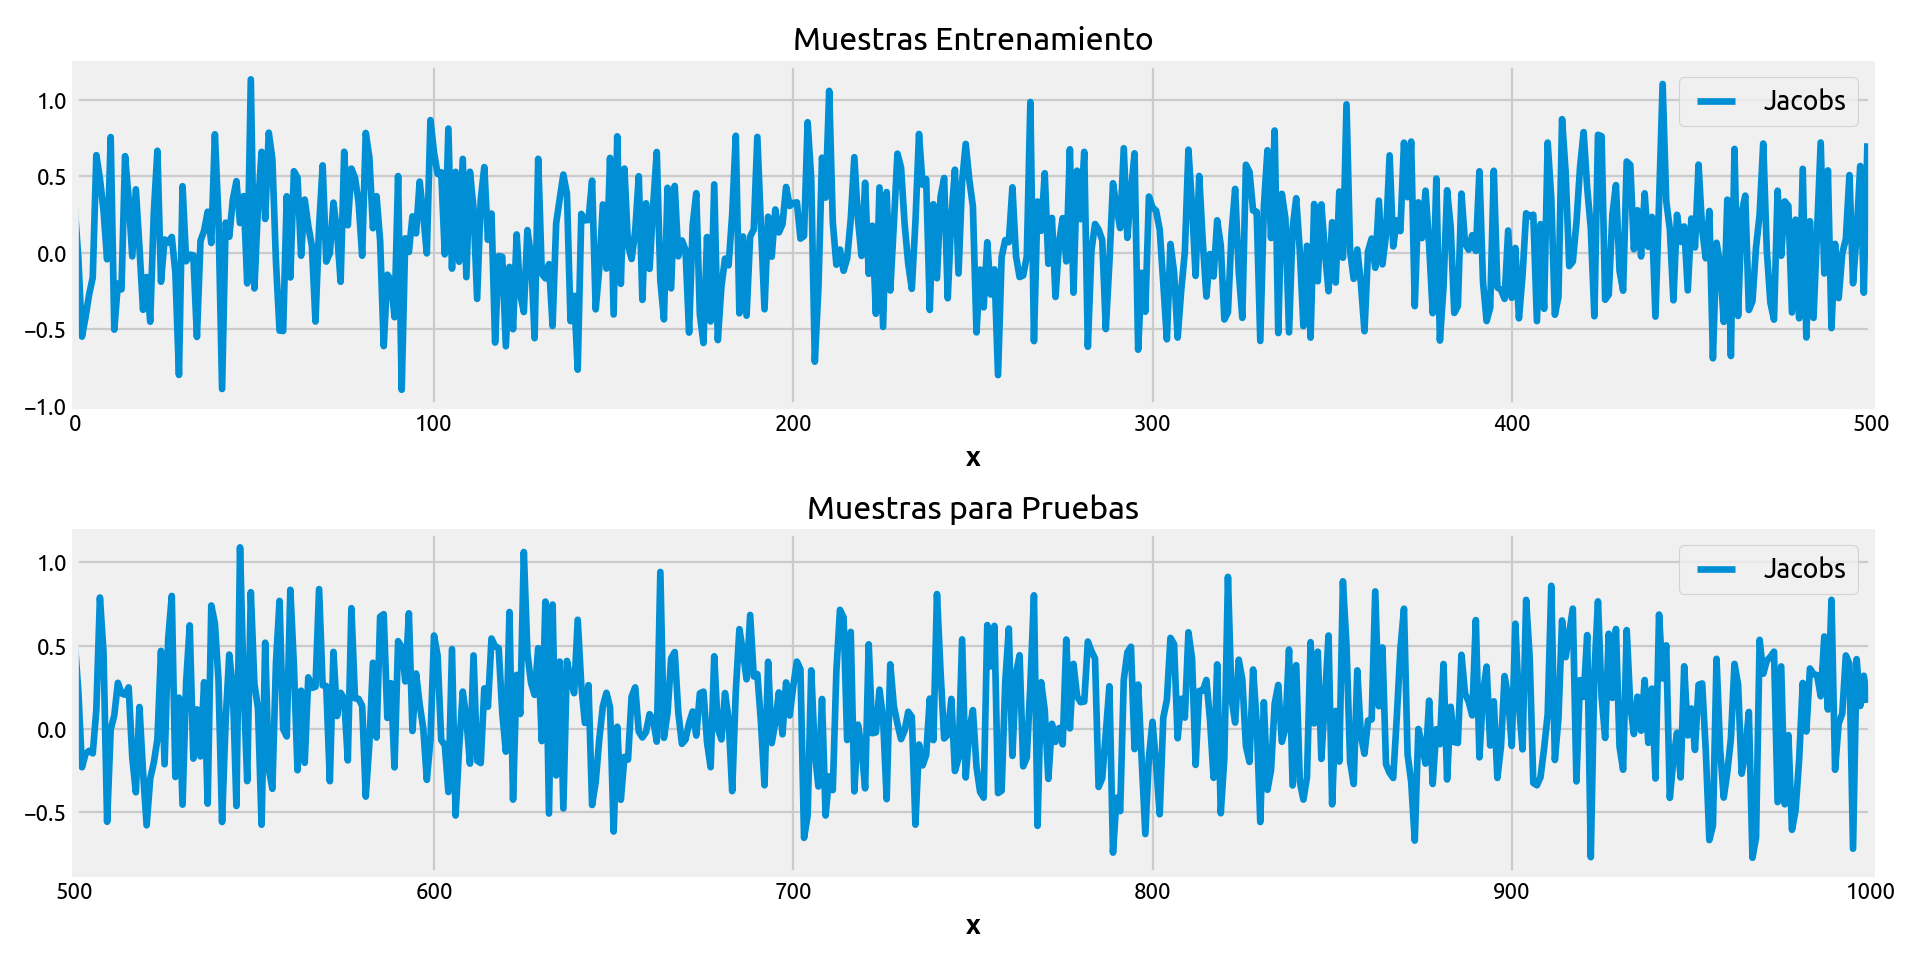

In [2]:
from matplotlib.pyplot import *
%matplotlib notebook

import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

fig = plt.figure(figsize=(12, 6), dpi=80)
ConfigPlot().set_size_font(10)

ax = plt.subplot(211)
ax.plot(t_train, fx_train, '-', lw=3, label='Jacobs')
plt.title('Muestras Entrenamiento')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.xlim([0, 500])
plt.tight_layout()

ax = plt.subplot(212)
ax.plot(t_test, fx_test, '-', lw=3, label='Jacobs')
plt.title('Muestras para Pruebas')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.xlim([500, 1000])
plt.tight_layout()

## Configure model parameters 

In [3]:
n_neurons = 15
n_models = 4
lr = 0.1
batch_size = 40
max_epoch = 500

n_ensemble_models = 4

fn_activation1 = ActivationFunctions.tanh
fn_activation2 = ActivationFunctions.tanh

n_features = X_train.shape[1]

n_output = y_train.shape[1]
n_inputs = n_features

n_neurons_model = int(0.75 * (n_output + n_inputs))

s = ITLFunctions.silverman(np.array(y_train)).eval()
print('Silverman: %0.4g' % s)

args_train_default = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True}

args_train_cip = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True,
              'criterion_update_params': 'cost', 'maximization_criterion': True}

Silverman: 0.1171


## Training MLP MSE

This MLP net has {{n_neurons_model}} neurons in hidden layer. The cost function is **MSE** and the update funtion is **SGD** (learning rate $\eta=${{lr}}).

In [4]:
# Create MLP
mlp = get_mlp_model("MLP MSE",
                    n_input=n_features, n_output=n_output,
                    n_neurons=n_neurons_model,
                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                    cost=mse, name_cost="MSE", params_update={'learning_rate': lr})

metrics_mlp = FactoryMetrics.get_metric(mlp)

# Compile
mlp.compile(fast=True)
                      
# training
metrics = mlp.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Comienza la compilación MLP MSE  - elapsed: 0.62 [s]
MLP MSE - fold: 1, epoch:[####################] 500/500 elapsed: 1.40[s] - left: 0.00[s] | score: 0.0105 / 0.0074
FINISHED!


## Training Ensemble MSE

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer. The cost function is **MSE** and the update funtion is **SGD** (learning rate $\eta=${{lr}}).

In [5]:
# Create Ensemble
ensemble = get_ensemble_model(name='Ensamble MSE',
                                  n_input=n_features, n_output=n_output,
                                  n_ensemble_models=n_ensemble_models, n_neurons_model=n_neurons_model,
                                  fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                  cost=mse, name_cost="MSE",
                                  params_update={'learning_rate': lr})

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

# Compile
ensemble.compile(fast=True)

# training
metrics = ensemble.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Comienza la compilación Ensamble MSE  - elapsed: 1.49 [s]
Ensamble MSE - fold: 1, epoch:[####################] 500/500 elapsed: 2.90[s] - left: 0.00[s] | score: 0.0154 / 0.0086
FINISHED!


## Training Ensemble NCL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer. The cost function is **NCL** (Negative Correlation Learning) and the update funtion is **SGD** (learning rate $\eta=${{lr}}). The parameter of **NCL** is $\lambda=0.1$.

In [6]:
# Create Ensemble NCL
ensembleNCL = get_ensembleNCL_model(name='Ensamble NCL',
                                        n_input=n_features, n_output=n_output,
                                        n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                        fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                        lamb=0.1, params_update={'learning_rate': lr})

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)

# Compile
ensembleNCL.compile(fast=True)
                      
# training
metrics = ensembleNCL.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Comienza la compilación Ensamble NCL  - elapsed: 4.80 [s]
Ensamble NCL - fold: 1, epoch:[####################] 500/500 elapsed: 5.22[s] - left: 0.00[s] | score: 0.0132 / 0.0082
FINISHED!


# Training Ensemble CIPL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer. The cost function is **CIPL** (Cross Informartion Potential Learning) and the update funtion is **SGD** (learning rate $\eta=-0.08$). The parameters of **CIPL** are $\beta=0.2$ and $\lambda=0.6$.

In [30]:
from deepensemble.combiner import *

# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIPL',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=0.2, lamb=0.6, s=s,
                                    lsp=1.5, lsm=0.5,
                                    lr=0.001,
                                    # fn_combiner=TheBestCombiner,
                                    # args_combiner={'n_models': n_ensemble_models},
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.08})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)

# Compile
ensembleCIP.compile(fast=False)
                      
# training
metrics = ensembleCIP.fit(X_train, y_train, **args_train_cip)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Comienza la compilación Ensamble CIPL  - elapsed: 16.40 [s]
Ensamble CIPL - fold: 1, epoch:[####################] 500/500 elapsed: 21.22[s] - left: 0.00[s] | score: 0.1048 / 0.09140
FINISHED!


<IPython.core.display.Javascript object>


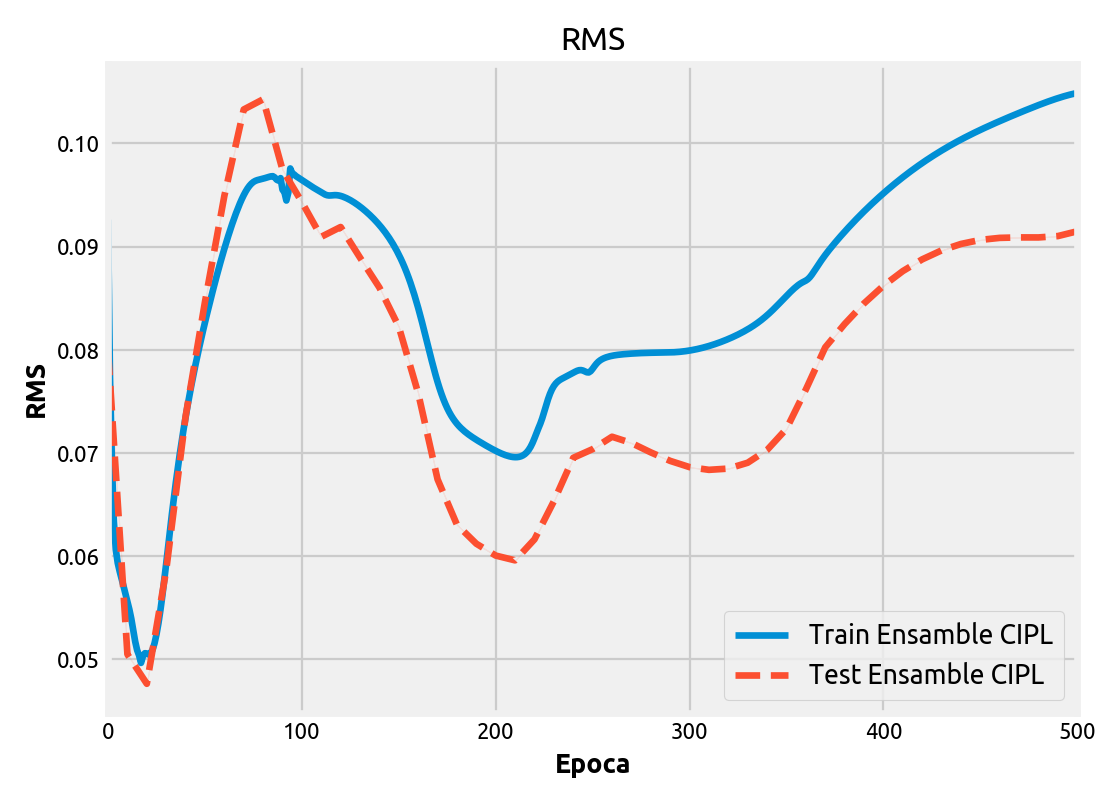

<IPython.core.display.Javascript object>


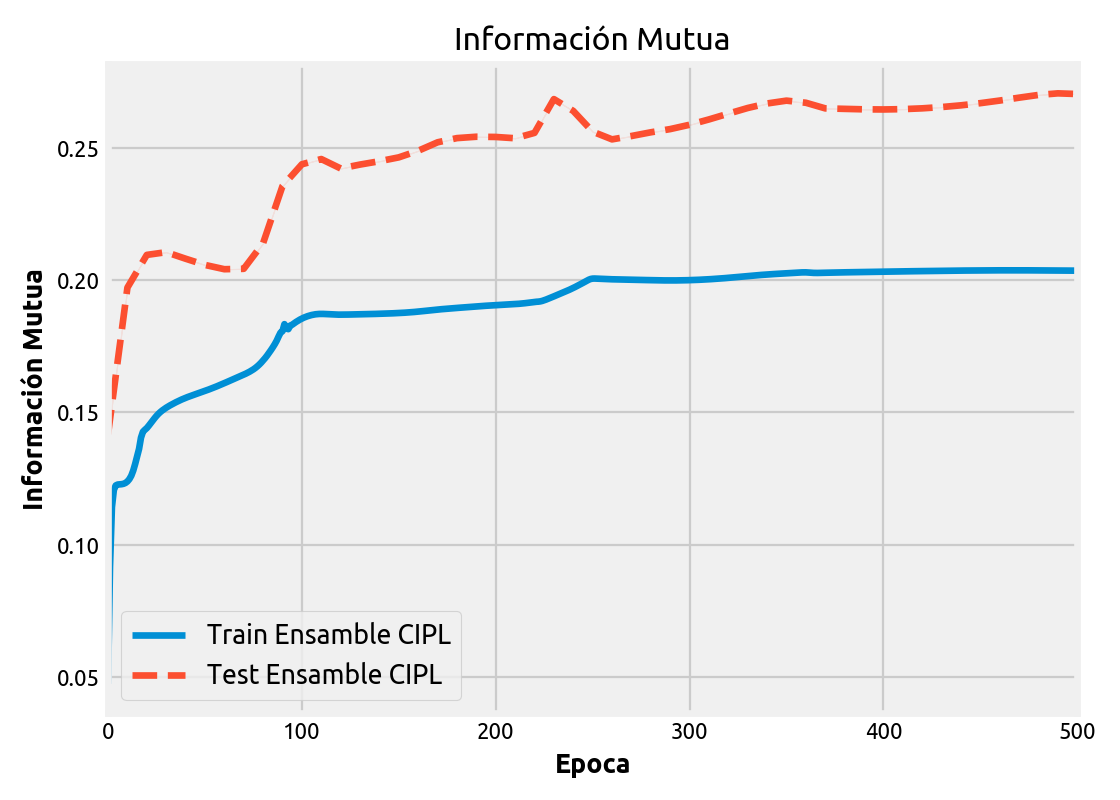

<IPython.core.display.Javascript object>


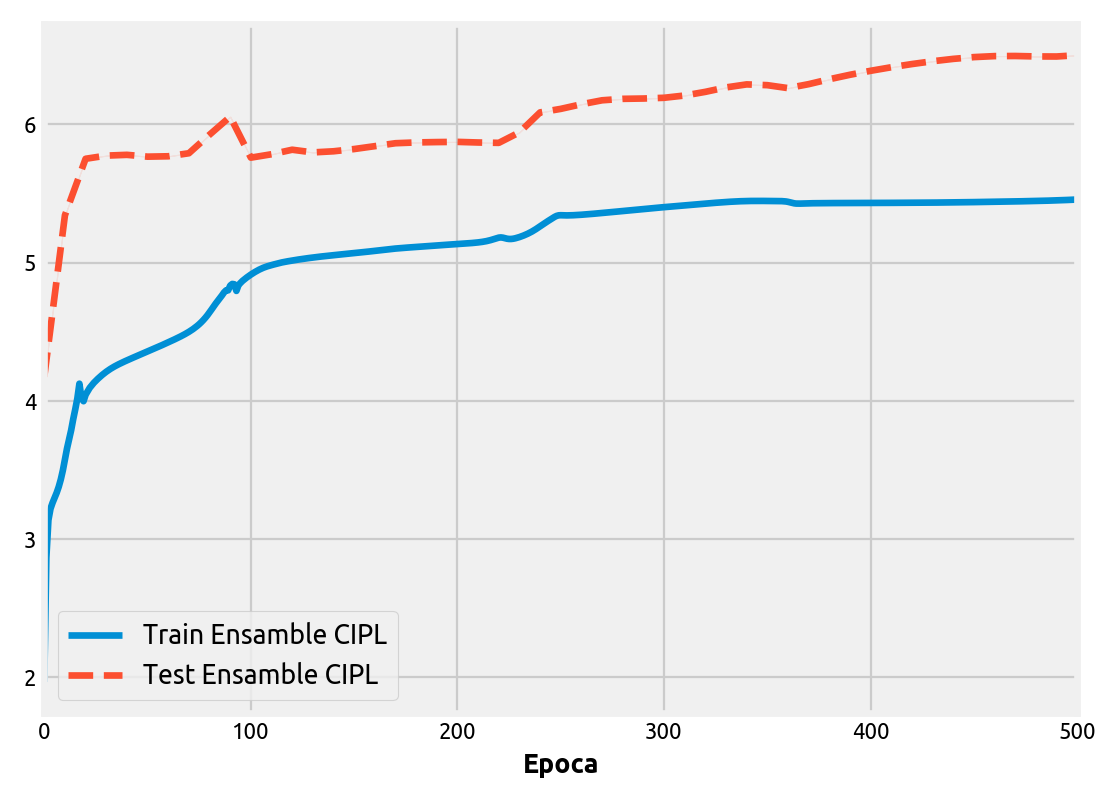

In [31]:
ConfigPlot().set_size_font(10)
ConfigPlot().set_dpi(80)
ConfigPlot().set_hold(False)
ConfigPlot().set_fig_size((7, 5))

metrics_ensembleCIP.plot_scores(max_epoch=max_epoch, title='')
metrics_ensembleCIP.plot_cost(max_epoch=max_epoch, title='')

plt.show()

## Summary model training

<IPython.core.display.Javascript object>


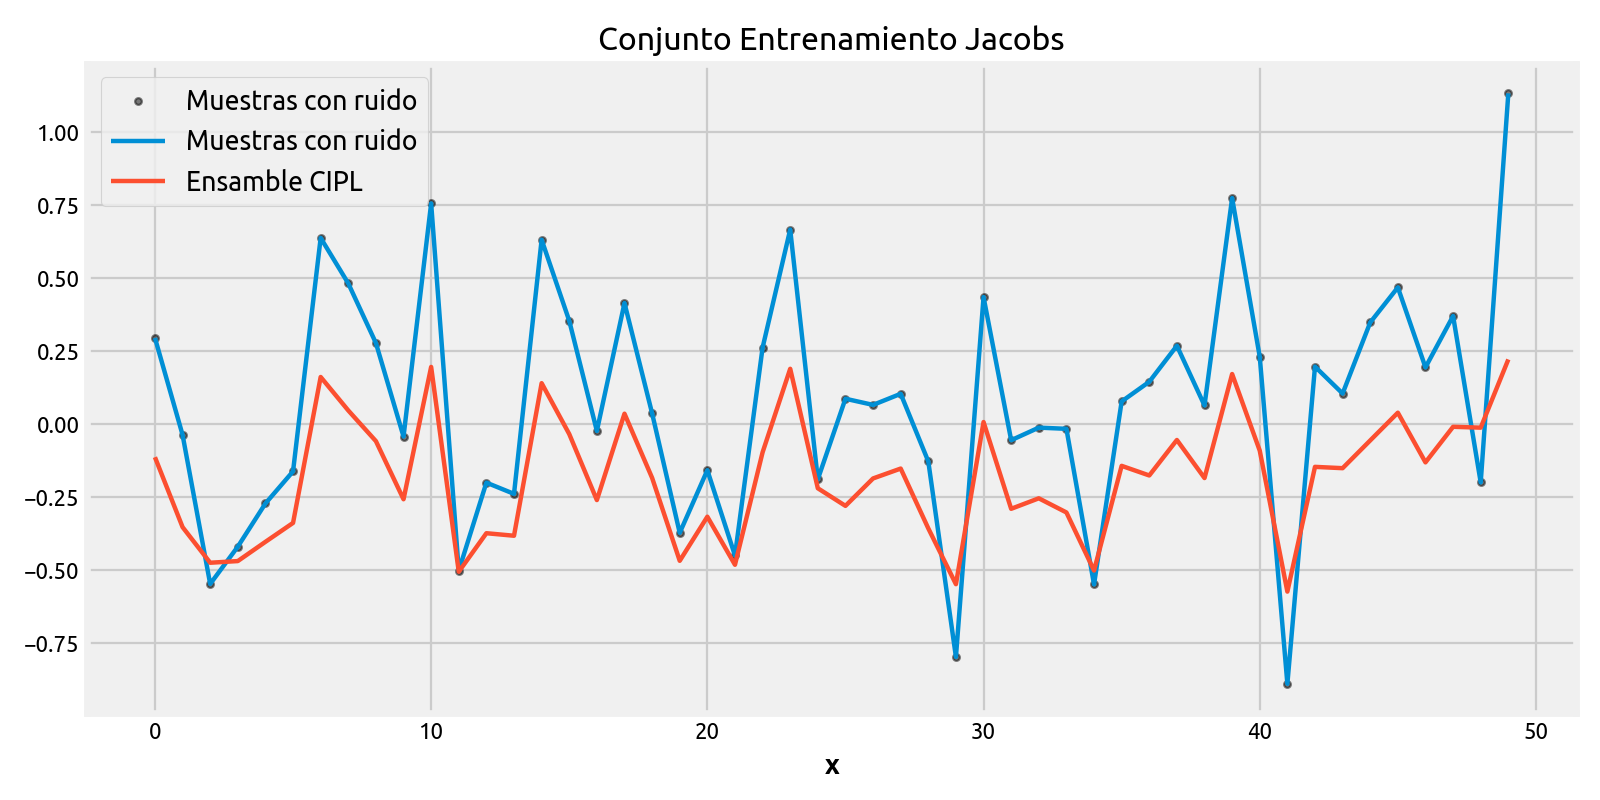

<IPython.core.display.Javascript object>


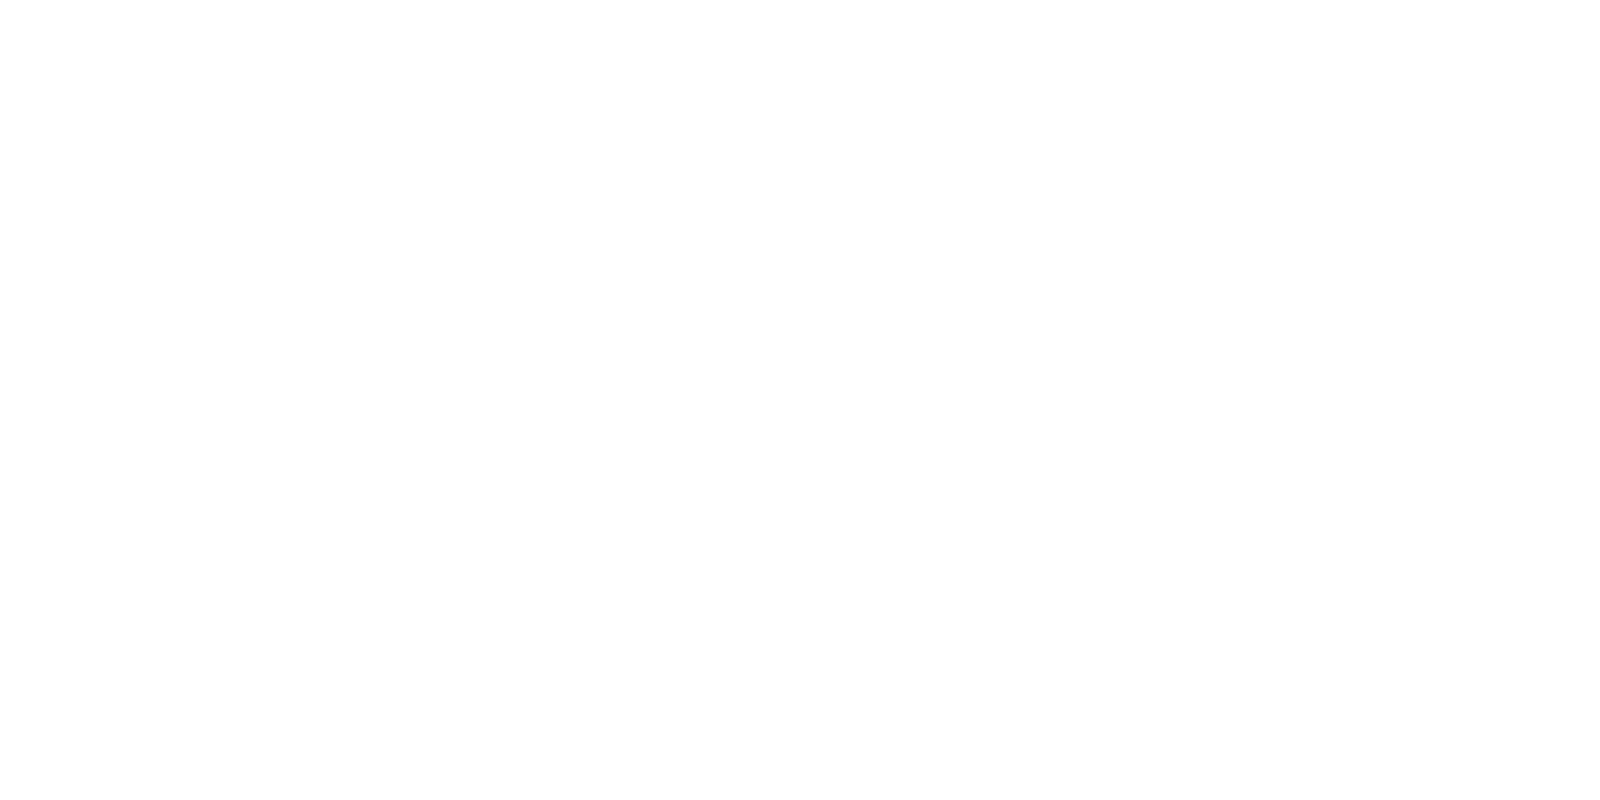

In [32]:
fig = plt.figure(figsize=(10, 5), dpi=80)

nm = 50

plt.plot(t_train[0:nm], z[0:nm], 'k.', alpha=0.5,  label='Muestras con ruido')
plt.plot(t_train[0:nm], y[0:nm], lw=2, label='Muestras con ruido')
plt.plot(t_train[0:nm], ensembleCIP.predict(X_train[0:nm]), lw=2, label='Ensamble CIPL')
plt.title('Conjunto Entrenamiento Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

fig = plt.figure(figsize=(10, 5), dpi=80)

plt.plot(t_test[0:nm], z[0:nm], 'k.', alpha=0.5, label='Muestras con ruido')
plt.plot(t_test[0:nm], y[0:nm], lw=2,label='Muestras con ruido')
plt.plot(t_test[0:nm], ensembleCIP.predict(X_test[0:nm]), lw=2, label='Ensamble CIPL')
plt.title('Conjunto Prueba Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

In [33]:
score_test_ensemble = ensemble.score(X_test, y_test)
score_train_ensemble = ensemble.score(X_train, y_train)

score_test_ensembleNCL = ensembleNCL.score(X_test, y_test)
score_train_ensembleNCL = ensembleNCL.score(X_train, y_train)

score_test_ensembleCIP = ensembleCIP.score(X_test, y_test)
score_train_ensembleCIP = ensembleCIP.score(X_train, y_train)

score_test_mlp = mlp.score(X_test, y_test)
score_train_mlp = mlp.score(X_train, y_train)

print('Score RMS')
print('Ensamble MSE: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble CIP: %f / %f' % (score_train_ensembleCIP, score_test_ensembleCIP))
print('MLP MSE: %f / %f' % (score_train_mlp, score_test_mlp))

Score RMS
Ensamble MSE: 0.015424 / 0.016619
Ensamble NCL: 0.013307 / 0.014830
Ensamble CIP: 0.108880 / 0.104756
MLP MSE: 0.010352 / 0.012068


<IPython.core.display.Javascript object>


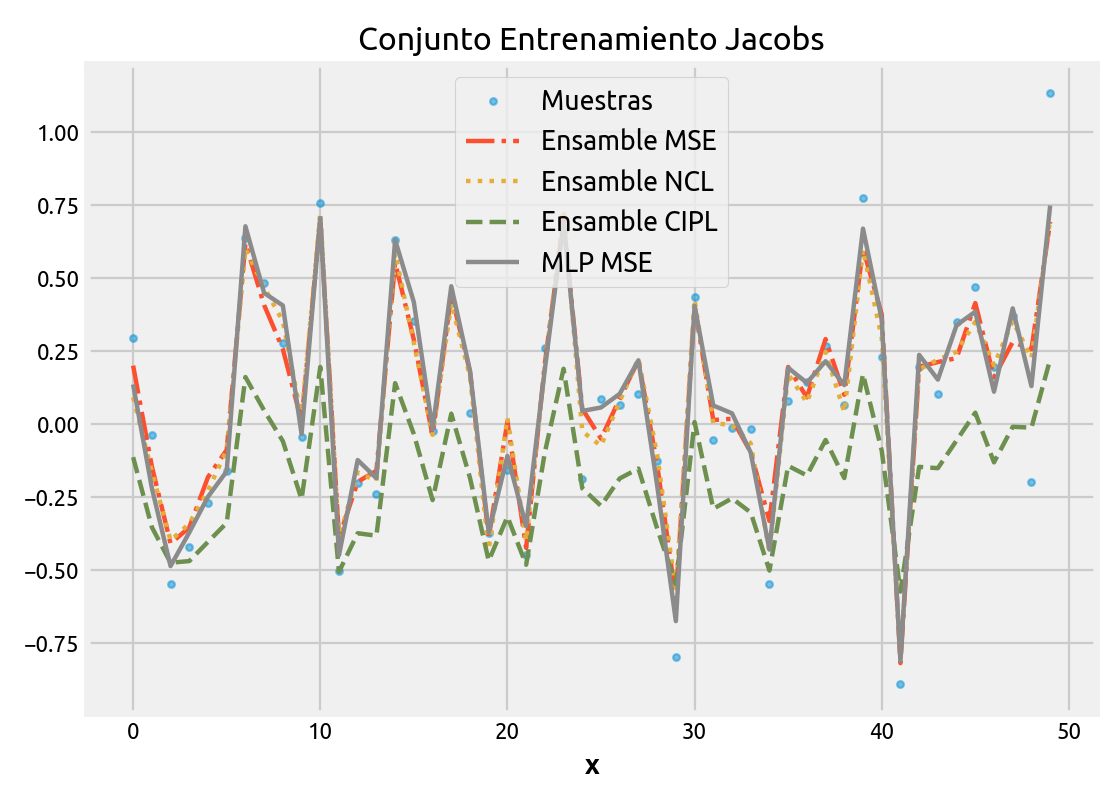

<IPython.core.display.Javascript object>


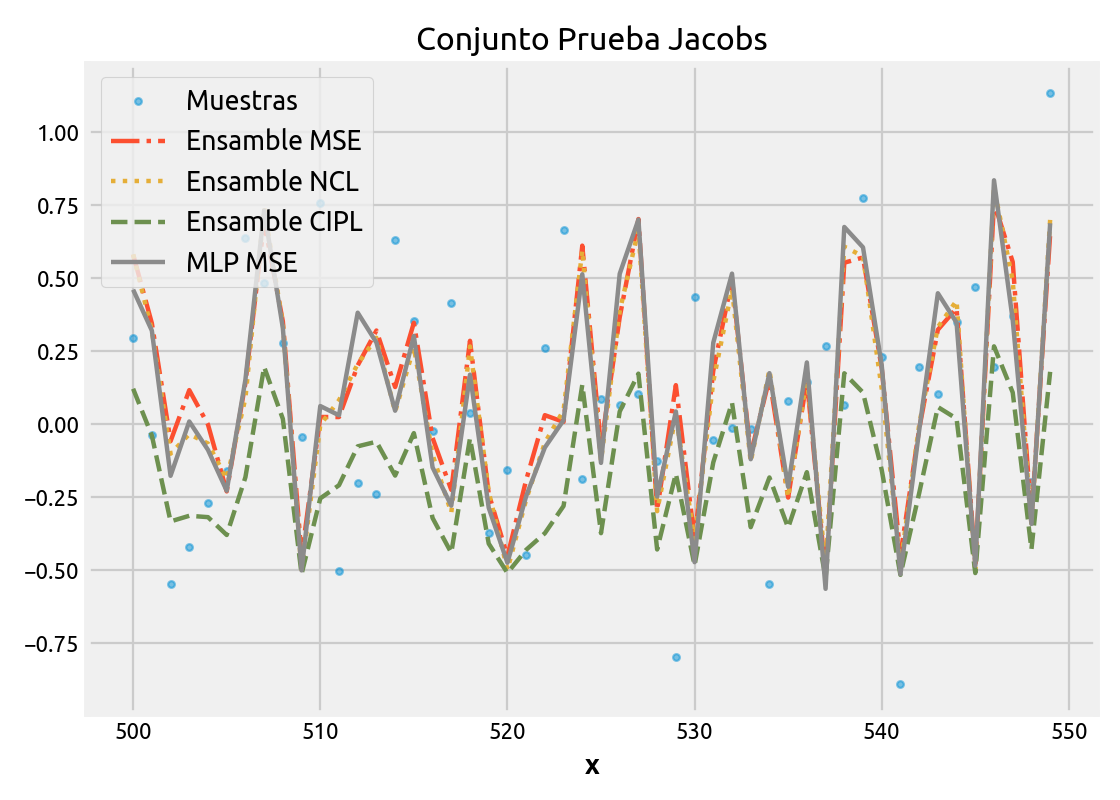

In [34]:
plt.close()

fig = plt.figure(figsize=(7, 5), dpi=80)

nm = 50

plt.plot(t_train[0:nm], z[0:nm], '.', alpha=0.5, label='Muestras')
plt.plot(t_train[0:nm], ensemble.predict(X_train[0:nm]), lw=2, linestyle='-.', label='Ensamble MSE')
plt.plot(t_train[0:nm], ensembleNCL.predict(X_train[0:nm]), lw=2, linestyle=':', label='Ensamble NCL')
plt.plot(t_train[0:nm], ensembleCIP.predict(X_train[0:nm]), lw=2, linestyle='--', label='Ensamble CIPL')
plt.plot(t_train[0:nm], mlp.predict(X_train[0:nm]), lw=2, linestyle='-', label='MLP MSE')
plt.title('Conjunto Entrenamiento Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

fig = plt.figure(figsize=(7, 5), dpi=80)

plt.plot(t_test[0:nm], z[0:nm], '.', alpha=0.5, label='Muestras')
plt.plot(t_test[0:nm], ensemble.predict(X_test[0:nm]), lw=2, linestyle='-.',  label='Ensamble MSE')
plt.plot(t_test[0:nm], ensembleNCL.predict(X_test[0:nm]), lw=2, linestyle=':',  label='Ensamble NCL')
plt.plot(t_test[0:nm], ensembleCIP.predict(X_test[0:nm]), lw=2, linestyle='--',  label='Ensamble CIPL')
plt.plot(t_test[0:nm], mlp.predict(X_test[0:nm]), lw=2, linestyle='-',  label='MLP MSE')
plt.title('Conjunto Prueba Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


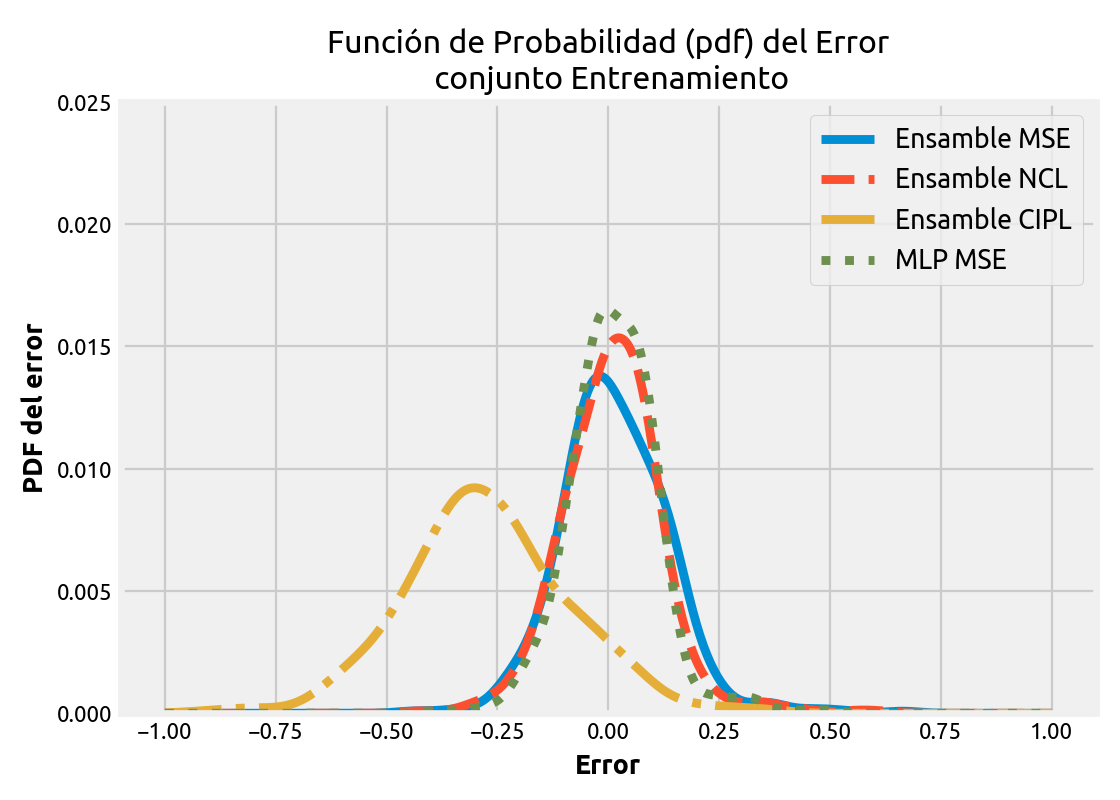

In [35]:
fig = plt.figure(figsize=(7, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error([ensemble, ensembleNCL, ensembleCIP, mlp], X_train, y_train,
               'Función de Probabilidad (pdf) del Error\n conjunto Entrenamiento',
               ax, fig, xmin=-1, xmax=1, lim_y=0.025)

plt.show()

<IPython.core.display.Javascript object>


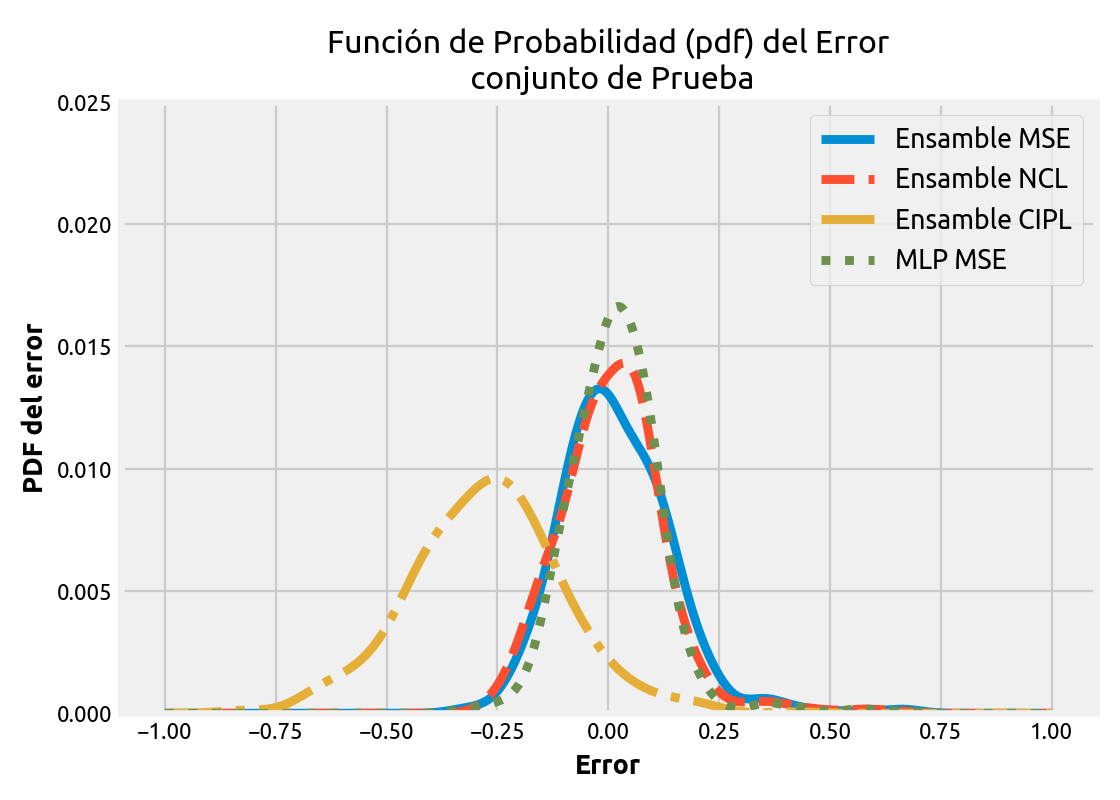

In [36]:
fig = plt.figure(figsize=(7, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error([ensemble, ensembleNCL, ensembleCIP, mlp], X_test, y_test,
               'Función de Probabilidad (pdf) del Error\n conjunto de Prueba',
               ax, fig, xmin=-1, xmax=1, lim_y=0.025)

plt.show()

<IPython.core.display.Javascript object>


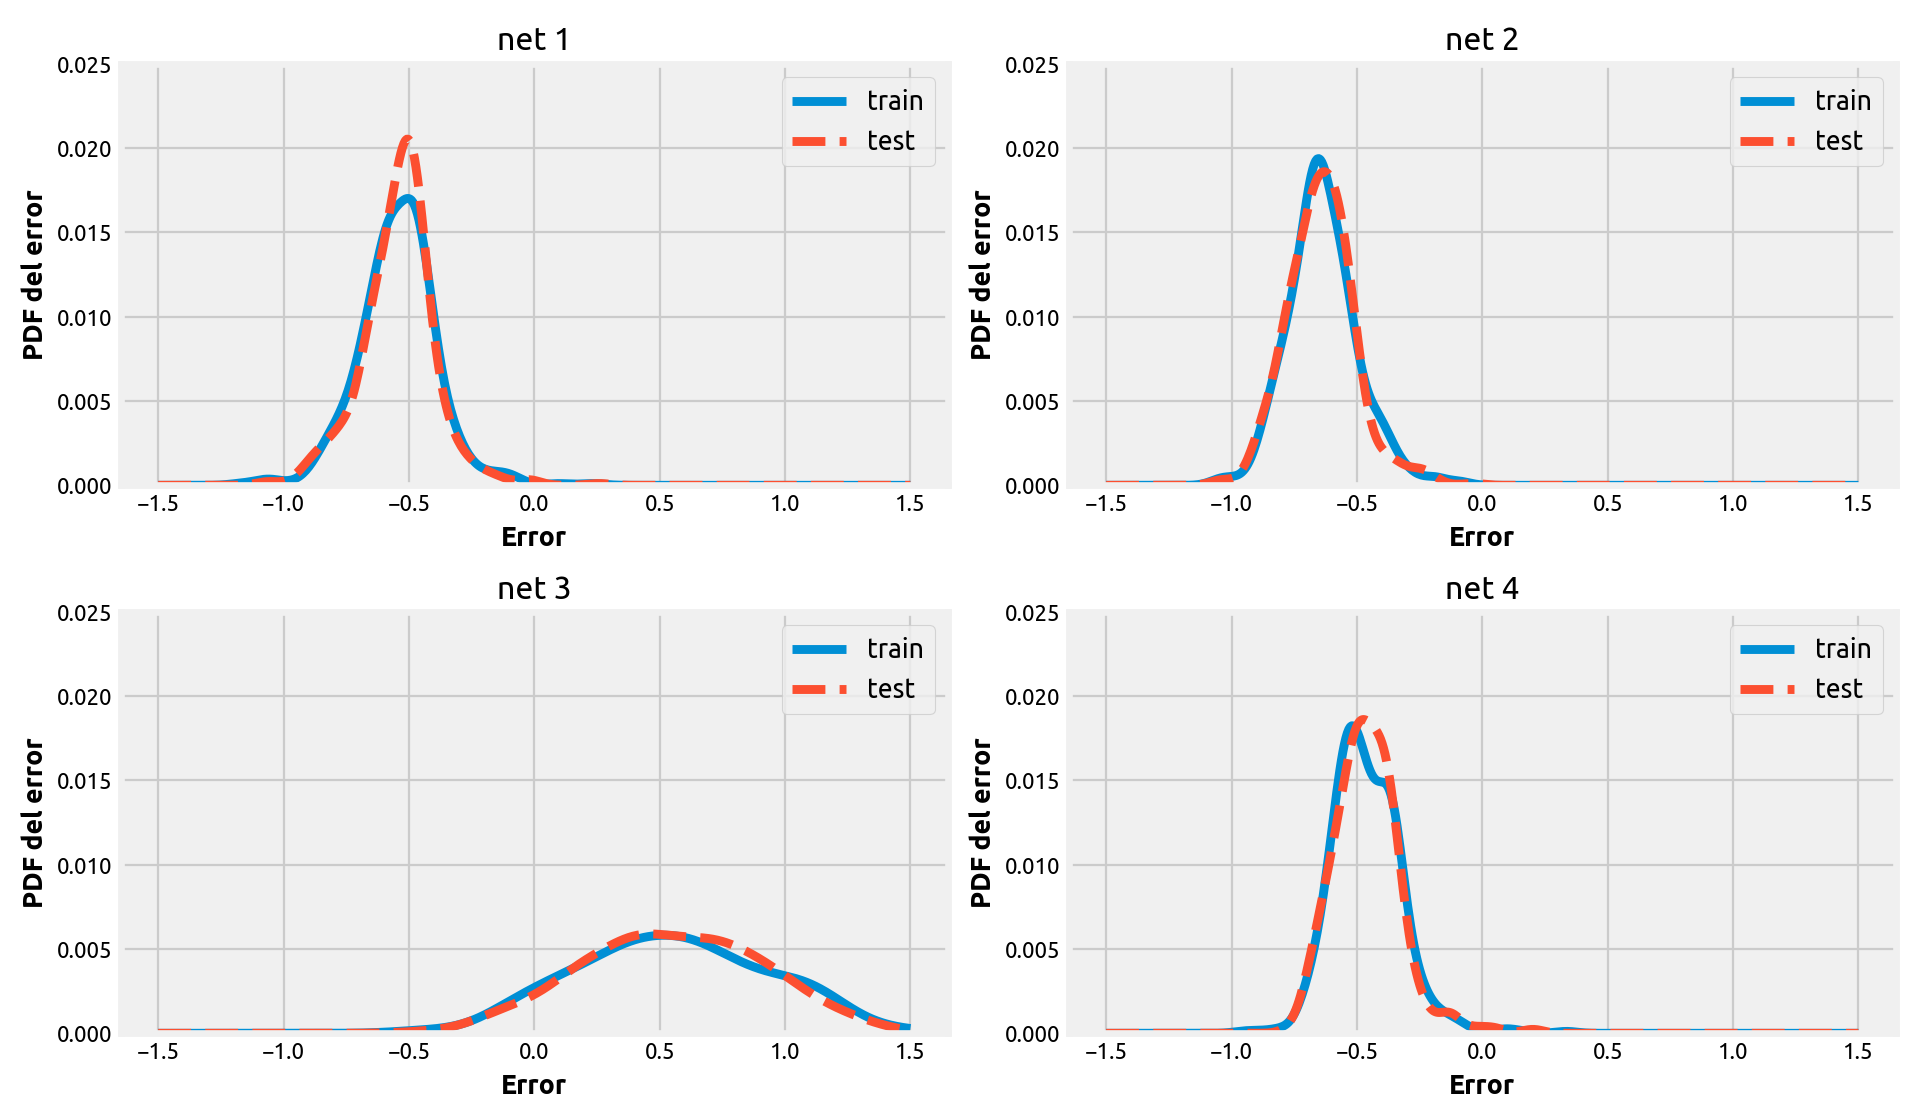

In [37]:
fig = plt.figure(figsize=(12, 3.5 * (n_ensemble_models // 2)), dpi=80)
for i in range(n_ensemble_models):
    ax = fig.add_subplot(n_ensemble_models // 2 + (n_ensemble_models % 2), 2, i + 1)
    plot_pdf_error_1(ensembleCIP.get_models()[i], X_train, y_train, 'net %d' % (i + 1), ax, fig, xmin=-1.5, xmax=1.5, lim_y=0.025, title='train', linestyle='-')
    plot_pdf_error_1(ensembleCIP.get_models()[i], X_test, y_test, 'net %d' % (i + 1), ax, fig, xmin=-1.5, xmax=1.5, lim_y=0.025, title='test', linestyle='--')
    

<IPython.core.display.Javascript object>


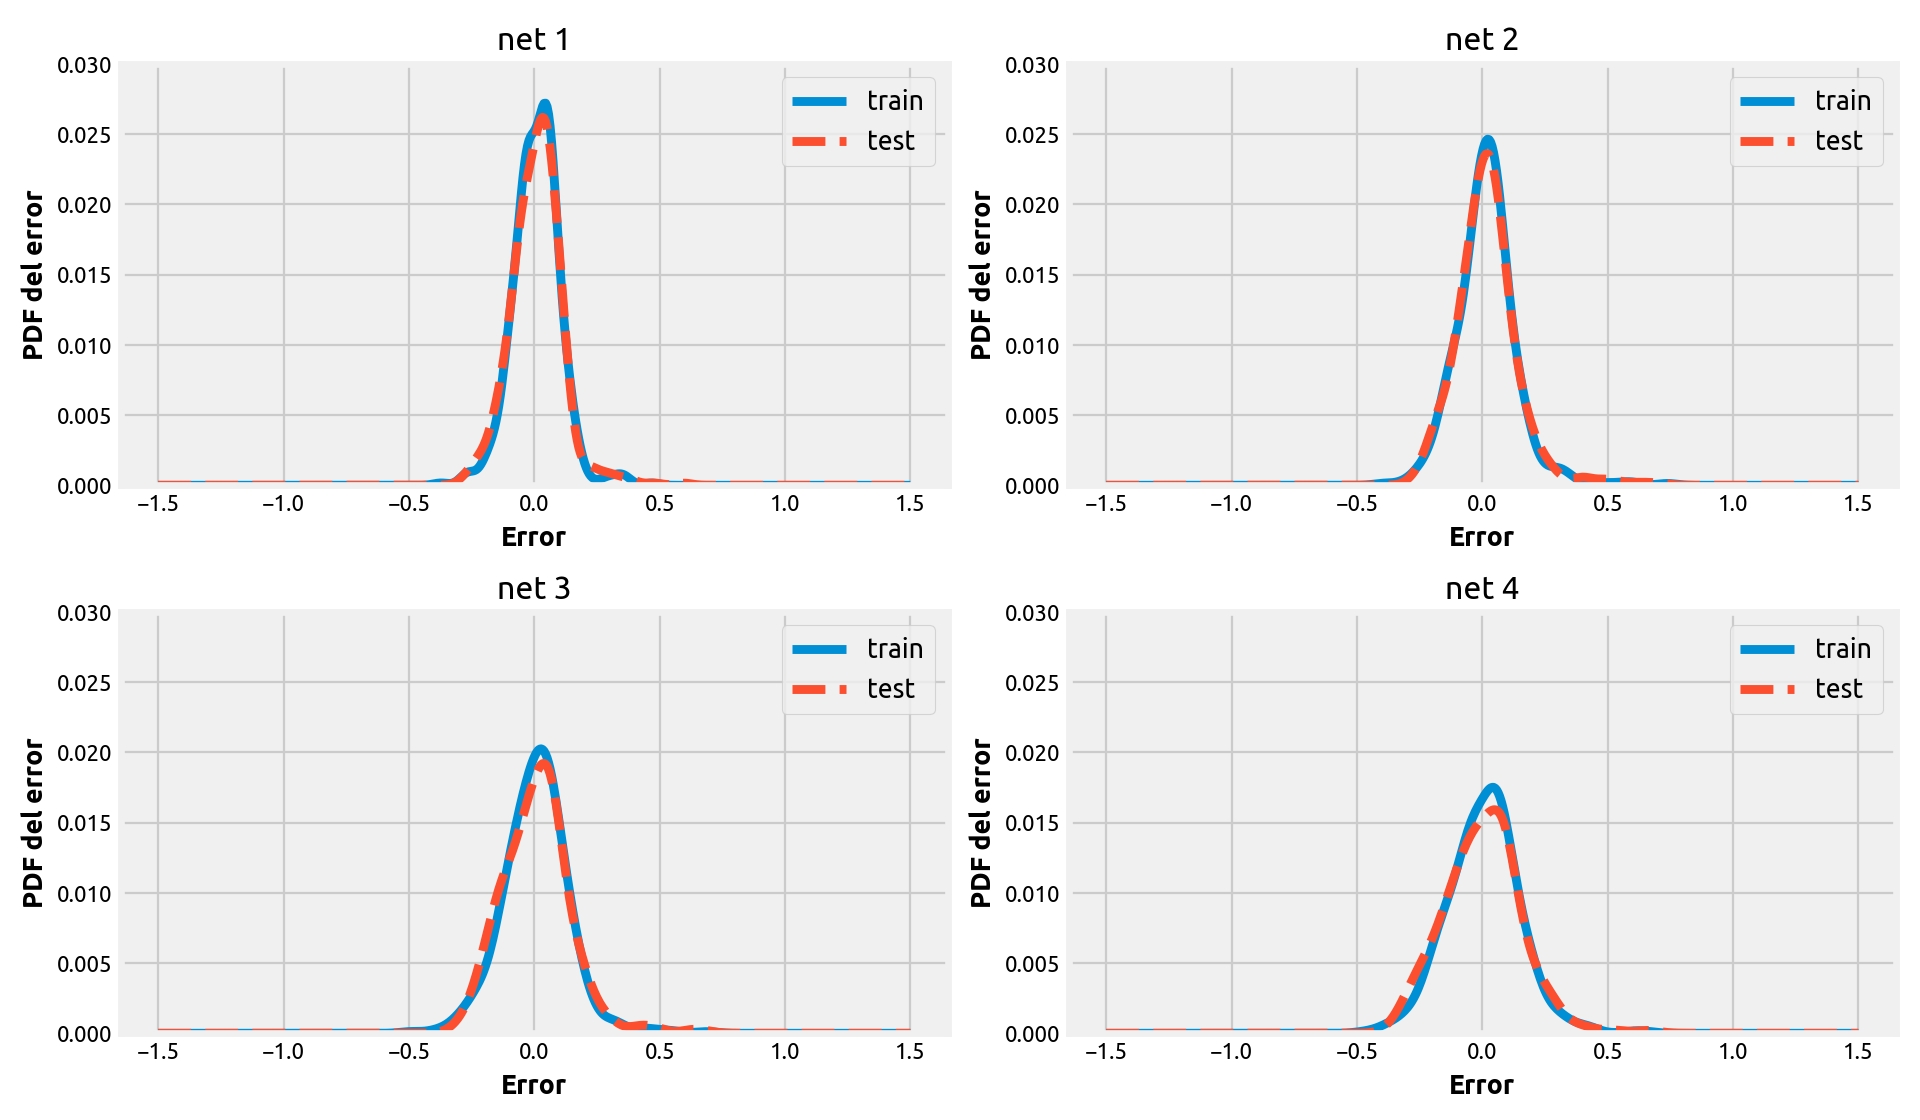

In [38]:
fig = plt.figure(figsize=(12, 3.5 * (n_ensemble_models // 2)), dpi=80)
for i in range(n_ensemble_models):
    ax = fig.add_subplot(n_ensemble_models // 2 + (n_ensemble_models % 2), 2, i + 1)
    plot_pdf_error_1(ensembleNCL.get_models()[i], X_train, y_train, 'net %d' % (i + 1), ax, fig, xmin=-1.5, xmax=1.5, lim_y=0.03, title='train', linestyle='-')
    plot_pdf_error_1(ensembleNCL.get_models()[i], X_test, y_test, 'net %d' % (i + 1), ax, fig, xmin=-1.5, xmax=1.5, lim_y=0.03, title='test', linestyle='--')
   